In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits import mplot3d
import pykep
import random
from scipy.optimize import newton
import csv
import pandas as pd
import math
from numpy.linalg import inv
import copy
import os
from pathlib import Path
from decimal import Decimal

Utility functions

In [2]:
def check_duplicates(data):
    duplicates = []
    i1 = 0
    for dict1 in data:
        i2 = 0
        for dict2 in data:
            if dict1 == dict2 and i1 != i2 and dict2 not in duplicates:
                duplicates.append(dict2)
            i2 +=1
        i1+=1
    if duplicates:
        return True, duplicates
    else:
        return False, duplicates
    

def check_points(point, data):
    if point[0] >= 0 and point[1] >= 0:
        for dict in data:
            if dict["Point"] == point:
                return False
        return True
    else:
        return False


In [3]:
def normalise_input(series):
    """
    Normalises the pandas dataframe and convert each entry to a np array represting a unit vector.
    Returns the normalised one.
    """
    series = series.str.strip("[ ")
    series = series.str.strip("[")
    series = series.str.strip("]")
    series = series.str.replace('  ',' ')
    for i in range(len(series)):
        series[i] = np.fromstring(series[i], sep=' ')
    return series

In [57]:
def to_global_axis(vector, r, v):
    """
    Calculates the rotation matrix and applies it. Returns the converted vector.
    r and v are used to calculate the rotation matrix and vector is the vector to be 
    rotated.
    """
    unit_r = r/np.linalg.norm(r)
    unit_v = v/np.linalg.norm(v)
    
    R = np.array([[Decimal(unit_v[0]), Decimal(-unit_r[0]), Decimal(unit_r[1]*unit_v[2] - unit_v[1]*unit_r[2])],
                [Decimal(unit_v[1]), Decimal(-unit_r[1]), Decimal(unit_v[0]*unit_r[2] - unit_r[0]*unit_v[2])],
                [Decimal(unit_v[2]), Decimal(-unit_r[2]), Decimal(unit_r[0]*unit_v[1] - unit_v[0]*unit_r[1])]])
    
    vec = R.dot(vector)
    return vec/np.linalg.norm(vec)

In [5]:
def normalise_orbit(orbit):
    i = 0
    for element in orbit:
        if math.isnan(element) is True:
            orbit[i] = False
        i+=1
    return orbit

In [6]:
def to_csv(data, filename):
    for dict1 in data:
        dict1.update({"Rho_i":dict1["Point"][0]})
        dict1.update({"Rho_f":dict1["Point"][1]})
    
    with open(filename, 'w', newline='') as f:
        fieldnames = ["Point", "Orbit", "Fit","Rho_i","Rho_f"]
        writer = csv.DictWriter(f, fieldnames=fieldnames)

        writer.writeheader()
        writer.writerows(data)

In [7]:
def evaluate_D(elementsO, TOF):
    mu = 398600  # km^3/s^2
    aO = elementsO[0]
    eO = elementsO[1]
    aT_max = 50000

    # some calculations
    rO_perigee = (1-eO)*aO
    vO_perigee = ((1+eO)/(1-eO) * mu/aO)**0.5
    vT_perigee_max = (2*mu/rO_perigee*(1-rO_perigee/(2*aT_max)))**0.5

    return (vO_perigee + vT_perigee_max)*TOF, rO_perigee

In [8]:
def create_grid(a, c=0.01):
    
    xs = np.arange(0,a, a*c)
    ys = np.arange(0,a, a*c)
    return xs, ys

In [9]:
def grid_between_lines(D, a):
    distances = []  # a list that will contain the whole population points (rho_i, rho_f)
    
    xs, ys = create_grid(a)
    for x in xs:
        for y in ys:
            if y < (x + D) and y > (x - D):
                distances.append([x,y])  # only add points that are between the lines

    #plt.plot(xc, yc, '.r')
    #plt.show()
    
    return distances

In [10]:
def get_elite(data, n=100):
    sorted_data = sorted(data, key=lambda x: x["Fit"], reverse=True)
    return sorted_data[:n]

def get_best(data):
    max_fit = 0
    i = 0
    for dict1 in data:
        fit = dict1["Fit"]
        if fit >= max_fit:
            if fit == max_fit:
                print("the same fit")
                print(data[i]["Point"])
                continue
            i_max = i
            max_fit = fit
        i += 1
    return data[i_max]


In [11]:
def show_pop(data):
    xs = []
    ys = []
    if isinstance(data[0], dict):
        for dict1 in data:
            xs.append(dict1["Point"][0])
            ys.append(dict1["Point"][1])
    
    else:
        for point in data:
            xs.append(point[0])
            ys.append(point[1])
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(xs, ys, '.k', markersize=5)
    ax.grid()
    plt.xlim(left=0)
    plt.ylim(bottom=0)

    plt.show()

Orbit as a function of time

In [12]:
def get_period(a, mu = 398600):
    """`
    return the period in seconds
    a needs to be in km
    """
    return (2*np.pi*a**1.5)/mu**0.5

def kepler(E, M_e, e):
    """Kepler's equation, to be used in a Newton solver."""
    return E - e * np.sin(E) - M_e

def d_kepler_d_E(E, M_e, e):
    """The derivative of Kepler's equation, to be used in a Newton solver.
    
    Note that the argument M_e is unused, but must be present so the function
    arguments are consistent with the kepler function.
    """
    return 1 - e * np.cos(E)

def time_since_perigee(elements):
    a = elements[0]
    e = elements[1]
    E = elements[5]
    E_mean = E - e*np.sin(E)
    T = get_period(a)
    return E_mean * T/(2*np.pi)

def propagate_based_on_vector(orbit, t,kepler):
    r, v = orbit
    rf, vf = pykep.propagate_lagrangian(r0 = r, v0 = v, tof = t,mu = 398600)
    rf = [Decimal(x) for x in rf]
    vf = [Decimal(x) for x in vf]
    return np.array(rf), np.array(vf)

def propagate_based_on_elements(elements, t, kepler):
    r, v = pykep.par2ic(elements, mu=398600)
    if t > 0:
        rf,vf = pykep.propagate_lagrangian(r0 = r, v0 = v, tof = t,mu = 398600)
    else:
        rf, vf = r, v
    if kepler == False:  # return vectors
        rf = [Decimal(x) for x in rf]
        vf = [Decimal(x) for x in vf]
        return np.array(rf),np.array(vf)
    if kepler == True:  # return kepler elements
        return pykep.ic2par(rf,vf,mu = 398600)
    
def propagate(orbit,t,kepler=False):
    if len(orbit) == 2:
        return propagate_based_on_vector(orbit,t,kepler)
    if len(orbit) == 6:
        return propagate_based_on_elements(orbit,t, kepler)

In [66]:
def convert_to_global(List_of_dic, elements):
    converted = []
    for dict1 in List_of_dic:
        for vec in dict1["list in body axis"]:
            t = vec[-1]
            hat = vec[:-1]
            r, v = propagate(elements,t,kepler=False)
            hat_converted = to_global_axis(hat,r,v)
            hat_converted = np.append(hat_converted, [t])
            converted.append(hat_converted)
        dict1["converted"] = converted

Unit vectors

In [13]:
def to_unit_vector(point, width=1080, height=1980 , AOV=np.radians(39.23)):
    """
    y points through the screen and x points right (CCW motion). Point is in cols, rows.
    Output corresponds to rows, cols.
    """
    distance_to_screen = (width**2+height**2)**0.5/(2*np.tan(AOV))
    vector = np.array((point[0]-height/2, distance_to_screen, width/2-point[1]))
    #print("vector in px", vector)
    vector = vector/np.linalg.norm(vector)
    return vector

In [14]:
def unit_vector(vector1, vector2):
    """
    returns the unit vector between two vectors.
    """
    rel = vector2 - vector1
    return rel/np.linalg.norm(rel)

def L_between_orbits(elements1, orbit, t, tof):
    """
    Input is two Kepler orbits in Kepler elements
    """
    r1, v1 = propagate(elements1, t, kepler=False)
    r2, v2 = propagate(orbit, tof, kepler=False)
    
    
    #print("Ideal pos  vector",r_ideal)
    rel = r2 - r1
    
    if np.linalg.norm(rel) ==0:
        
        return None
    #print("ideal rel vec", rel_ideal)
    unit = rel/np.linalg.norm(rel)
    #print("ideal rel unit vec",rel_ideal/np.linalg.norm(rel_ideal))
    return unit


Lambert's problem

In [15]:
def constraints(r,v, rO_perigee):
    """
    Return true if satisfied.
    """
    elements = pykep.ic2par(r,v,mu=398600)
    a = elements[0]
    e = elements[1]
    R_earth = 6371 # km
    if R_earth + 200 <= a and a <= 50000 and 0 <= e and e <= 1: # aT_max = 50000 km
        return True
    else:
        return False

In [16]:
def get_target_r(elementsO, rel_initial, rel_final, point, ti,tof):
    """
    The inputs are the observer elements and target posistion vectors as unit vectors in observer CS.
    For final measurments they are propagated forward in time (t).
    Point corresponds to a chromosome.
    Returns intial and final target posistion vectors.
    """
    # initial "measurment" and orbit
    rho_i = Decimal(point[0])
    rO_initial, vO_initial = propagate(elementsO, ti, kepler=False)
    rT_i = rho_i*rel_initial + rO_initial
    # final "measurment" and orbit
    rho_f = Decimal(point[1])
    rO_final, vO_final = propagate(elementsO, ti+tof, kepler=False)
    rT_f = rho_f*rel_final + rO_final
    return rT_i, rT_f

In [17]:
def solve_lambert(ri, rf, t):
    """
    Solves the lambert problem. Input two posistion vector and the time between those locations.
    Returns the solution in Kepler elements.
    """
    # solve Lambert's problem
    ri = np.array([float(x) for x in ri])
    rf = np.array([float(x) for x in rf])
    l = pykep.lambert_problem(r1 = ri, r2 = rf, tof = t, mu=398600)
    # convert results
    vi = l.get_v1()[0]  # get the velocity vector at initial time for one revolution
    return ri, vi

In [18]:
def Lambert_problem(data, elementsO, rT_initial, rT_final, point, rO_perigee, ti, TOF):
    # set up Lambert's problem
    ri, rf = get_target_r(elementsO, rT_initial, rT_final, point, ti,TOF)
    
    # solve Lambert's problem
    ri, vi = solve_lambert(ri, rf, t = TOF)
    if constraints(ri,vi, rO_perigee) is True:
        new_dict = dict(Point = point, Orbit = [ri, vi])
        data.append(new_dict)
    if constraints(ri,vi, rO_perigee) is False:
        raise ValueError
    return data

Genetic algorithm building blocks

In [19]:
def expand_point(point, k):
    x,y = point
    return [[x + k, y], [x, y + k], [x - k, y], [x, y - k], [x + k, y + k], [x - k, y - k], [x + k, y - k], [x - k, y + k]]


In [20]:
def mutate(data, elementsO, r_initial, r_final, rO_perigee, ti, TOF, index):
    """
    mutates a single data point given by index. If the point doesn't satisfy conditions then
    the function returns False.
    """
    stnd_devs = [-10,-1,1,10]
    added = 0
    for stnd_dev in stnd_devs:
        new_points = expand_point(data[index]["Point"],stnd_dev)
        for new_point in new_points:
            if check_points(new_point,data) is True:  # not a duplicate or a neg value
                try:
                    data = Lambert_problem(data, elementsO, r_initial, r_final, new_point, rO_perigee, ti, TOF)
                    added += 1
                except ValueError:
                    continue 
    if added > 0:
        return True, data
    else:
        return False, data

def mutation(data, elementsO, r_initial, r_final, rO_perigee, ti, TOF, no_of_outputs):
    """
    Input how many extra chromoses are wanted.
    """
    print("number of points to mutate", no_of_outputs)
    indices = [x for x in range(len(data))]
    
    last_length = len(data)
    final_length = last_length + no_of_outputs
    
    while len(data) != final_length:
        
        if len(data) < final_length:
            passed = False
            while passed is False:
                index = random.choice(indices)  # get a random entry from list
                indices.remove(index)  # remove that entry to avoid duplicates
                passed, data = mutate(data, elementsO, r_initial, r_final, rO_perigee, ti, TOF, index)  
                #print(passed)
                if passed == True:
                    no_of_successful_mutations = len(data) - last_length 
                    #print(no_of_successful_mutations)
                    #print("at", no_of_successful_mutations, "duplictes", check_duplicates(data))
                if not indices:  # list is empty
                    #print("no of successful mutations", no_of_successful_mutations)
                    indices = [x + last_length for x in range(no_of_successful_mutations)]  # mutate the mutated points further
                    #print(indices)
                    last_length = len(data)
                    no_of_successful_mutations = 0
                    if not indices:
                        indices = [x for x in range(last_length)]
                        #print(indices)
                    

        if len(data) > final_length:
            no_of_extra_points = len(data) - final_length 
            
            for i in range(no_of_extra_points):
                index = random.randint(0, len(data)-1)
                
                data.pop(index)
            
        
    return data

In [21]:
def one_crossover(point1, point2, data, D):
    if np.random.randint(0,2) == 1:
        #print("first point1",point1)
        #print("first point2",point2)
        point1[1] = point2[1]
        #print("second point1",point1)
        #print("second point2",point2)
        if abs(point1[0] - point1[1]) < D and abs(point2[0] - point2[1]) < D:
            #print("passed up")
            return point1
        else:
            return False
    else:
        point2[1] = point1[1]
        if abs(point1[0] - point1[1]) < D and abs(point2[0] - point2[1]) < D:
            #print("passed down")
            return point2
        else:
            return False

def get_random_points(data):
    index1 = random.randint(0, len(data) - 1)
    index2 = random.randint(0, len(data) - 1)
    while index1 == index2:  # can't be the same
        index2 = random.randint(0, len(data) - 1)
    point1 = data[index1]["Point"]
    point2 = data[index2]["Point"]
    return point1, point2

def crossover(data, elementsO, r_initial, r_final, rO_perigee, ti, TOF, no_of_outputs, D):
    for i in range(no_of_outputs):
        passed = False
        while passed is False:
            point1, point2 = get_random_points(data)
            extra_point = one_crossover(point1, point2, data,D)
            while extra_point == False:
                point1, point2 = get_random_points(data)
                extra_point = one_crossover(point1, point2, data,D)  # the inequality must be satisfied
            try:
                data = Lambert_problem(data, elementsO, r_initial, r_final, extra_point, rO_perigee, ti, TOF)  # solve for orbits
                passed = True
            except ValueError:
                passed = False  # will go back into the loop and select a new random point that passes the constraints
    return data


In [22]:
# fitness with a cross product
def fitness(elementsO, set_of_measurments, estimated_orbit,test=False):
    fit = Decimal(1)
    t_initial = set_of_measurments[0][-1]
    #print("initial time", t_initial)
    for coordinates in set_of_measurments:
        t = coordinates[-1]
        
        #print("pos vector of sat", r,v)
        #print("measured unit vector in body CS", coordinates)
        L_measurment = coordinates[:-1]
        tof = t - t_initial
        L_ast = L_between_orbits(elementsO, estimated_orbit,t,tof)
        if L_ast is not None:
            cross = np.cross(L_measurment, L_ast)
            cross_mod = np.linalg.norm(cross)
            if test is True:
                print("time",t)
                print("L ast", L_ast)
                print("measured unit vector in global CS", L_measurment)
                
                print("cross product", cross)
                print("cross product lenth", cross_mod)
            #print("norms", np.linalg.norm(L_measurment),np.linalg.norm(L_ast))
            fit = fit*(Decimal(1)-cross_mod)
    return fit

In [23]:
def fitness(elementsO, set_of_measurments, estimated_orbit,test=False):
    fit = Decimal(1)
    t_initial = set_of_measurments[0][-1]
    #print("initial time", t_initial)
    for coordinates in set_of_measurments:
        t = coordinates[-1]
        
        #print("pos vector of sat", r,v)
        #print("measured unit vector in body CS", coordinates)
        L_measurment = coordinates[:-1]
        tof = t - t_initial
        L_ast = L_between_orbits(elementsO, estimated_orbit,t,tof)
        if L_ast is not None:
            if test is True:
                print("time",t)
                print("L ast", L_ast)
                print("measured unit vector in global CS", L_measurment)
                print("dot", np.dot(L_measurment, L_ast))
            #print("norms", np.linalg.norm(L_measurment),np.linalg.norm(L_ast))
            fit = fit * np.dot(L_measurment, L_ast)
    return fit**4

def objective_func(elementsO, set_of_measurments, data):
    for og_dict in data:
        fit_value = fitness(elementsO, set_of_measurments, og_dict["Orbit"])
        og_dict["Fit"] = fit_value   # fitness value in the data
    return data


In [24]:
def get_pop(elementsO, rel_intial, rel_final, ti, TOF,a):
    D, rO_perigee = evaluate_D(elementsO, TOF)
    # get an evenly spaced grid between two lines Rho in the range [0,9000]
    original_population = grid_between_lines(D,a)  # initial population
    data = []
    #print("grid")
    #show_pop(original_population)

    for point in original_population:
        try:
            data = Lambert_problem(data, elementsO, rel_intial, rel_final, point, rO_perigee, ti, TOF)
        except ValueError:
            continue
    return data, rO_perigee

In [25]:
def initialise_pop(elementsO, rel_intial, rel_final, ti, TOF, N=1000, limit=9000):
    """
    Initialises the population of specific size based on initial and final "measurments".
    The inputs are the observer orbit and the inital and final posistion vector for the target.
    Returns a list of dictionaries.
    """
    data, rO_perigee = get_pop(elementsO, rel_intial, rel_final, ti, TOF,a=limit)
    
    n = len(data)
    print("initial size", n)

    if n < 0.5*N:
        # try initialising data again
        limit = int(max(data[-1]["Point"])*1.1)
        print("range", limit)
        data, rO_perigee = get_pop(elementsO, rel_intial, rel_final, ti, TOF,a=limit)
        n = len(data)  
        print("second iteration", n)
    
    if n > N:
        # remove the number of extra points randomly
        no_of_extra_points = int(n - N)
        print("extra points", no_of_extra_points, type(no_of_extra_points))
        for x in range(no_of_extra_points):
            index = random.randint(0, len(data)-1)
            data.pop(index)

    if n < N:
        # gain extra points via mutation
        no_of_extra_points = N - n
        #print(no_of_extra_points)
        data = mutation(data, elementsO, rel_intial, rel_final, rO_perigee, ti, TOF, no_of_extra_points)  
        
    return data,limit

Stop conditions

In [26]:
def mean(data):
    n = len(data)
    sum_i = 0
    sum_f = 0
    for dict1 in data:
        sum_i += dict1["Point"][0]
        sum_f += dict1["Point"][1]
    return sum_i/n, sum_f/n    

def covariance_matrix(data):
    """
    Returns the standard deviations of the population in terms of two variables.
    Our points consist of initial and final distance.
    """
    c11 = 0
    c12 = 0
    c22 = 0
    mean_i, mean_f = mean(data)
    n = len(data)
    for dict1 in data:
        c11 += (dict1["Point"][0]-mean_i)**2
        c12 += (dict1["Point"][0]-mean_i)*(dict1["Point"][1]-mean_f)
        c22 += (dict1["Point"][1]-mean_f)**2
    return np.sqrt(c11/n), np.sqrt(c22/n), np.sqrt(c12/n)

def last_similarity(List, error = 0):
    """
    The input list should be a list (2x2) in a list of length phi.
    Return true if all the elements in the list are similar (same) compared to the last element.
    """
    point = List[-1]
    if all(x ==  point for x in List):
        return True
    else:
        return False
    
def stop_criteria(data, last_means, last_best_values, no_of_gens,lim_O = 5, lim_F = 5, max_gen=30,error = 0):
    """
    Returns True if met.
    """
    # for means
    means_sim = last_similarity(last_means)
    # for best values
    best_sim = last_similarity(last_best_values)
    # standard values
    sigma_OO, sigma_FF, sigma_OF = covariance_matrix(data)
    #print("standard dev", sigma_OO, sigma_FF, sigma_OF)
    
    if means_sim == True:
        print("similarity in means")
        return True
    
    if best_sim == True:
        print("similarity in last best")
        return True
    
    if no_of_gens >= max_gen:
        print("max gens")
        return True, None, None
    if sigma_OO <= lim_O and sigma_FF <= lim_F:
        print("stnd dev")
        return True
    else:
        return False  # need these values for the next iteration

Initialisation

In [27]:
#elements_sat = [7133.8,0.0043,np.radians(98.289), np.radians(49.866), np.radians(356.768), 2.605101240816877]
elements_sat = [7350,0.0037296,np.radians(82.0394),np.radians(41.7294),np.radians(216.168),np.radians(0)]

In [34]:
%store -r elements_sat

In [36]:
%store -r line

In [38]:
set_of_measurments = line[15:]

In [27]:
set_of_measurments = new_test

In [6]:
# measurments from detecting objects
data_meas = pd.read_csv('data/measurments.csv')
set_of_measurments = data_meas.loc[1]  #choose which line to check
set_of_measurments = normalise_input(set_of_measurments.dropna())

initial size 942


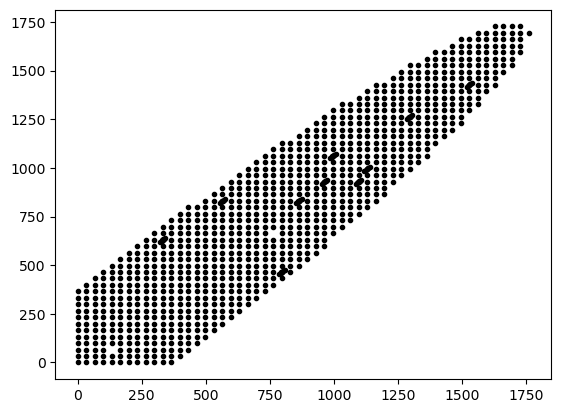

1000


In [36]:
r1 = set_of_measurments[0][:-1]
r2 = set_of_measurments[-1][:-1]
tof = set_of_measurments[-1][-1] - set_of_measurments[0][-1]
ti = set_of_measurments[0][-1]
# initialise
data = initialise_pop(elements_sat, r1, r2, ti, TOF=tof)
show_pop(data)
print(len(data))

In [37]:
data = objective_func(elements_sat, set_of_measurments, data)

In [38]:
check_duplicates(data)

(False, [])

In [39]:
data_elite = get_elite(data)

In [40]:
data_test = copy.deepcopy(data_elite)

In [41]:
best_point = get_best(data)["Point"]
no_of_gens = 0
phi = 3
print("best point", best_point)
last_means = [(0,0) for x in range(phi)]
last_means.pop(0)
last_means.append(mean(data))

last_best_values = [(0,0) for x in range(phi)]
last_best_values.pop(0)
last_best_values.append(best_point)

D, rO_perigee = evaluate_D(elements_sat, tof)  # maybe there is a better way to define this

best point [896.678966789668, 963.09963099631]


Body

In [260]:
data_crossover = crossover(data_test, elements_sat, r1,r2, rO_perigee, ti, tof, 50, D)

In [42]:
while stop_criteria(data, last_means, last_best_values, no_of_gens) is False:
    #print("iteration", no_of_gens)
    data_elite = get_elite(data)
    
    # create new population and corresponding orbits
    data_created = initialise_pop(elements_sat, r1, r2, ti, TOF=tof, N=50)  # create 5% of desired population size
    
    data_elite = data_elite + data_created
    
    #mutate
    data_mutation = mutation(data_elite, elements_sat, r1,r2, rO_perigee, ti, tof, 800)  # 800 corresponds to 80% of desired population 
    #print("mutation", check_duplicates(data_mutation))
    # crossover
    data_crossover = crossover(data_mutation, elements_sat, r1,r2, rO_perigee, ti, tof, 50, D)  # crossover 5% of desired population size
    data = data_crossover
    #print("final", len(data))
    print("crossover", check_duplicates(data_crossover))
    # get new fit_values
    data = objective_func(elements_sat, set_of_measurments, data)
    
    # update last_means, last_best_values, no_of_gens
    last_means.pop(0)
    last_means.append(mean(data))
    #print("last means", last_means)
    best_point = get_best(data)["Point"]
    #print("the best", best_point)
    last_best_values.pop(0)
    last_best_values.append(best_point)
    #print("last bests", last_best_values)
    no_of_gens += 1
else:
    print("donzo")

initial size 49
crossover (True, [{'Point': [1495.0, 1645.0], 'Orbit': [30889.666163067068, 0.8105440999080302, 0.8210634595254327, 0.0005452382557348577, 0.10984092091192843, -0.026644560597202688]}, {'Point': [795.0479704797049, 861.468634686347], 'Orbit': [8296.007602174945, 0.2096496472565083, 0.5154839814208572, 0.00016505133035898479, 0.06352964330061558, -0.03566072923973657]}, {'Point': [1352.0, 1502.0], 'Orbit': [19616.846143594656, 0.6952274938582717, 0.7777594747118916, 0.0007428326110015264, 0.16717630068828823, -0.06022358325732403]}])
initial size 49
crossover (False, [])
initial size 49
crossover (False, [])
initial size 49
crossover (False, [])
initial size 49
crossover (False, [])
similarity in last best
donzo


In [43]:
best_ones = []

In [44]:
best = get_best(data)
best_ones.append(best)
best_ones

[{'Point': [442.7343173431735, 475.9446494464945],
  'Orbit': [7251.530635158399,
   0.04727894735094815,
   0.3043583371135131,
   6.283181747953716,
   6.272813707430835,
   0.02599273515476623],
  'Fit': 0.9999999996746358}]

All in one

In [118]:
directory = "data/Test/"
os.listdir(directory)

['measurments_data_0_0_M1.csv',
 'measurments_data_0_0_M2.csv',
 'measurments_data_0_0_M3.csv']

In [ ]:
for filename in os.listdir(directory):
    print("file", filename)
    path = directory + filename
    # measurments from detecting objects
    data_meas = pd.read_csv(path)
    for index, row in data_meas.iterrows():
        data = []
        set_of_measurments = normalise_input(row.dropna())

        #set up the pop
        r1 = set_of_measurments[0][:-1]
        r2 = set_of_measurments[-1][:-1]
        tof = set_of_measurments[-1][-1] - set_of_measurments[0][-1]
        ti = set_of_measurments[0][-1]
        # initialise
        data = initialise_pop(elements_sat, r1, r2, ti, TOF=tof)
        # run the objective func
        data = objective_func(elements_sat, set_of_measurments, data)

        #initialise the body of the alogithm
        best_point = get_best(data)["Point"]
        no_of_gens = 0
        phi = 3
        #print("best point", best_point)
        last_means = [(0,0) for x in range(phi)]
        last_means.pop(0)
        last_means.append(mean(data))

        last_best_values = [(0,0) for x in range(phi)]
        last_best_values.pop(0)
        last_best_values.append(best_point)

        D, rO_perigee = evaluate_D(elements_sat, tof)  # maybe there is a better way to define this
        # body
        while stop_criteria(data, last_means, last_best_values, no_of_gens) is False:
            #print("iteration", no_of_gens)
            data_elite = get_elite(data)
            
            # create new population and corresponding orbits
            data_created = initialise_pop(elements_sat, r1, r2, ti, TOF=tof, N=50)  # create 5% of desired population size
            
            #mutate
            data_mutation = mutation(data_elite, elements_sat, r1,r2, rO_perigee, ti, tof, 700)  # 800 corresponds to 80% of desired population 
            #print("mutation", check_duplicates(data_mutation))
            # crossover
            data_crossover = crossover(data_mutation, elements_sat, r1,r2, rO_perigee, ti, tof, 150, D)  # crossover 5% of desired population size
            data = data_crossover + data_created
            
            #print("final", len(data))
            #print("crossover", check_duplicates(data_crossover))
            # get new fit_values
            data = objective_func(elements_sat, set_of_measurments, data)
            
            # update last_means, last_best_values, no_of_gens
            last_means.pop(0)
            last_means.append(mean(data))
            #print("last means", last_means)
            best_point = get_best(data)["Point"]
            #print("the best", best_point)
            last_best_values.pop(0)
            last_best_values.append(best_point)
            #print("last bests", last_best_values)
            no_of_gens += 1
        else:
            print("donzo")
            best = get_best(data)
            print(best)
            df = pd.DataFrame(data)
            name = Path(filename).stem[12:] + "_" + str(index)
            df.to_csv("results/{}.csv".format(name))


Ideal case

In [139]:
%store -r all_coordinates

In [138]:
%store -r all_rel
convert_to_global(all_rel, elements_sat)

In [139]:
all_coordinates = all_rel

file data_0_0
initial size 28
range 495
second iteration 7096
extra points 6096 <class 'int'>
initial population
1000


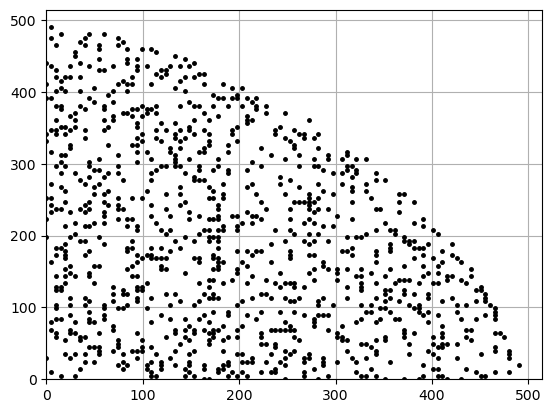

C:\Users\kuubikus\AppData\Local\Temp\ipykernel_8392\2388724908.py:24: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(c11/n), np.sqrt(c22/n), np.sqrt(c12/n)


no of gens 0
initial size 7096
extra points 7046 <class 'int'>
number of points to mutate 800


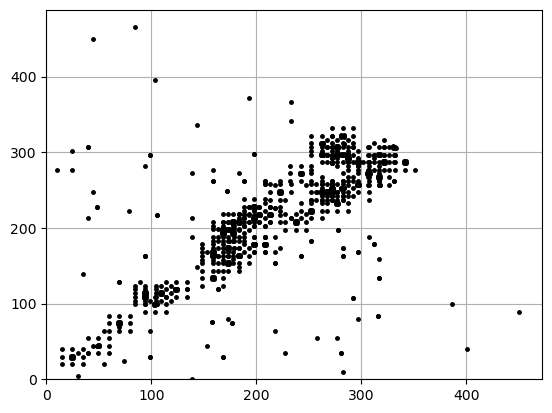

no of gens 1
initial size 7096
extra points 7046 <class 'int'>
number of points to mutate 800


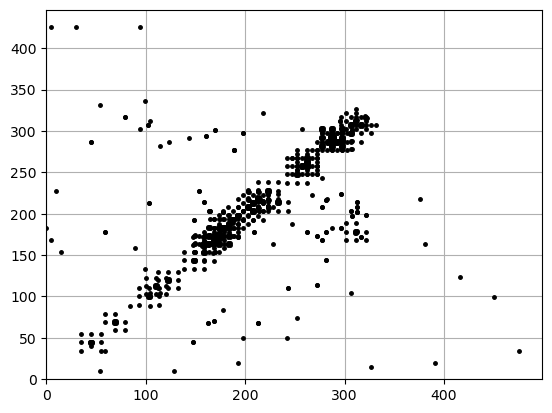

no of gens 2
initial size 7096
extra points 7046 <class 'int'>
number of points to mutate 800


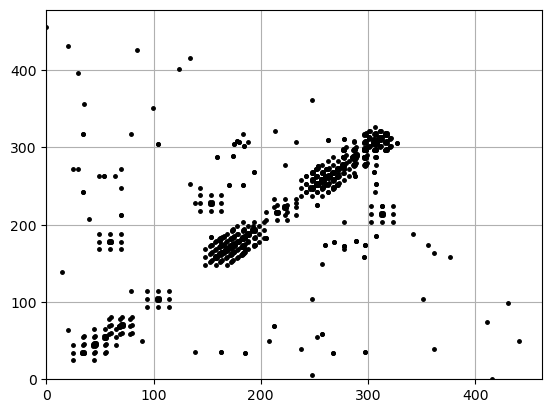

no of gens 3
initial size 7096
extra points 7046 <class 'int'>
number of points to mutate 800


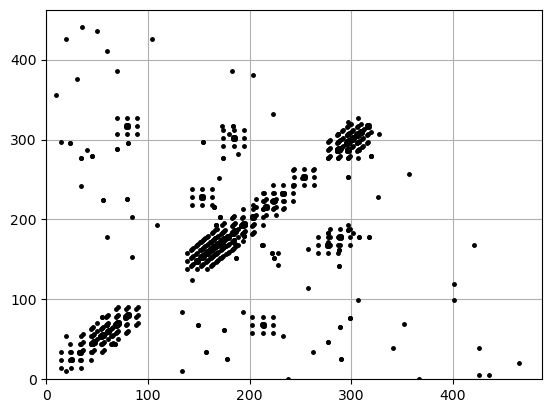

no of gens 4
initial size 7096
extra points 7046 <class 'int'>
number of points to mutate 800


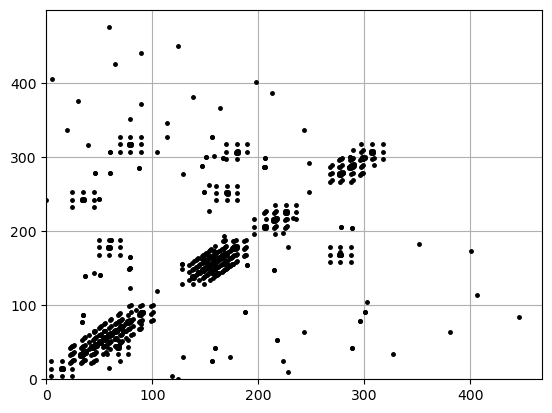

no of gens 5
initial size 7096
extra points 7046 <class 'int'>
number of points to mutate 800


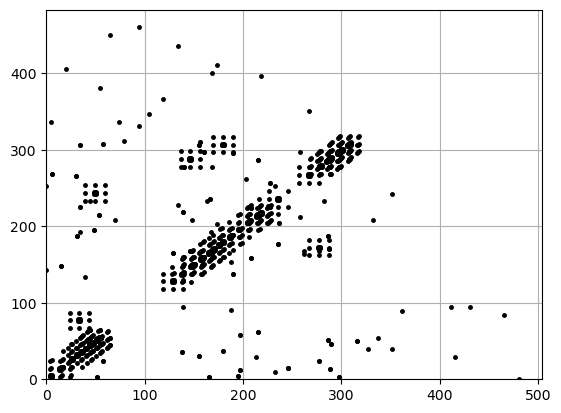

no of gens 6
initial size 7096
extra points 7046 <class 'int'>
number of points to mutate 800


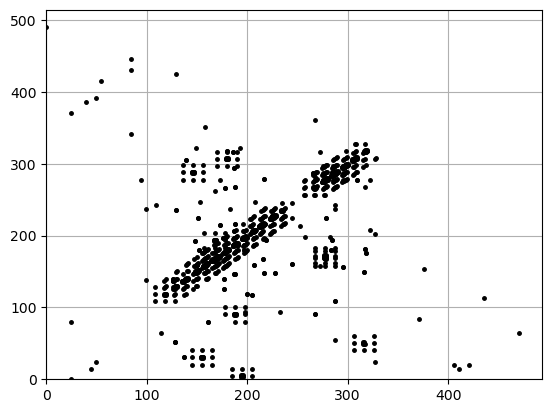

similarity in last best
donzo
best {'Point': [157.4, 157.3], 'Orbit': [array([-4017.92662842, -4297.61541622, -4151.32191827]), (5.05850380912805, 2.1530753237344347, -6.824029195962067)], 'Fit': Decimal('0.9999997284870801114145595152')}
mean [(217.07764999999895, 219.38824999999943), (189.0268499999999, 188.31714999999937), (141.43650000000062, 156.6137000000009), (171.43949999999901, 177.77090000000007), (214.00809999999987, 203.79259999999843)]
covariance (63.578256537829105, 76.51098614081515, 43.9972997175963)


In [143]:
directory = "data/ideal"
for dict1 in all_coordinates:
    filename = dict1["name"]
    print("file", filename)
    
    # measurments from detecting objects
    #set_of_measurments = dict1["list in global axis"]
    set_of_measurments = dict1["converted"]
    
    #set up the pop
    r1_hat = set_of_measurments[0][:-1]
    r2_hat = set_of_measurments[-1][:-1]
    tof = set_of_measurments[-1][-1] - set_of_measurments[0][-1]
    ti = set_of_measurments[0][-1]
    # initialise
    data, limit = initialise_pop(elements_sat, r1_hat, r2_hat, ti, TOF=tof, N=1000)
    print("initial population")
    print(len(data))
    show_pop(data)
    # run the objective func
    data = objective_func(elements_sat, set_of_measurments, data)

    #initialise the body of the alogithm
    best_point = get_best(data)["Point"]
    no_of_gens = 0
    phi = 5
    #print("best point", best_point)
    last_means = [(0,0) for x in range(phi)]
    last_means.pop(0)
    last_means.append(mean(data))

    last_best_values = [(0,0) for x in range(phi)]
    last_best_values.pop(0)
    last_best_values.append(best_point)

    D, rO_perigee = evaluate_D(elements_sat, tof)  # maybe there is a better way to define this
    # body
    
    while stop_criteria(data, last_means, last_best_values, no_of_gens) is False:
        print("no of gens", no_of_gens)
        #print("iteration", no_of_gens)
        data_elite = get_elite(data, n=100)
       
        # create new population and corresponding orbits
        data_created, limit = initialise_pop(elements_sat, r1_hat, r2_hat, ti, TOF=tof, N=50, limit=limit)  # create 5% of desired population size
            
        #mutate
        data_mutation = mutation(data_elite, elements_sat, r1_hat,r2_hat, rO_perigee, ti, tof, 800)  # 800 corresponds to 80% of desired population 
        #print("mutation", check_duplicates(data_mutation))
        # crossover
        data_crossover = crossover(data_mutation, elements_sat, r1_hat,r2_hat, rO_perigee, ti, tof, 50, D)  # crossover 5% of desired population size
        data = data_crossover + data_created
        
        #print("final", len(data))
        #print("crossover", check_duplicates(data_crossover))
        # get new fit_values
        data = objective_func(elements_sat, set_of_measurments, data)
            
        # update last_means, last_best_values, no_of_gens
        last_means.pop(0)
        last_means.append(mean(data))
        #print("last means", last_means)
        best_point = get_best(data)["Point"]
        #print("the best", best_point)
        last_best_values.pop(0)
        last_best_values.append(best_point)
        #print("last bests", last_best_values)
        show_pop(data)
        no_of_gens += 1
    else:
        print("donzo")
        best = get_best(data)
        print("best", best)
        print("mean", last_means)
        print("covariance", covariance_matrix(data))
        #df = pd.DataFrame(data)
        name = filename 
        #df.to_csv("results/ideal/{}.csv".format(name))
    

In [146]:
r,v = best["Orbit"]
elements = pykep.ic2par(r,v, mu=398600) 
elements = list(elements)
for i in range(4):
    i += 2
    elements[i] = np.degrees(elements[i])
elements

[11749.969443471724,
 0.38762273082248394,
 78.0257084700285,
 38.31966331140927,
 220.1730766597972,
 -2.69876473796194]

In [145]:
%store -r orbits

For taking one single list of measurments from data gen for predefined orbits


In [28]:
%store -r test
%store -r test2

In [362]:
ti = 0
new_list = []
for point in test:
    t = point[-1]
    r,v = propagate(elements_sat,t, kepler=False)
    r.astype(np.longdouble)
    unit = to_global_axis(point[:-1],r,v)
    unit = np.append(unit, [t])
    
    new_list.append(unit)

initial size 281
range 9207
second iteration 272
number of points to mutate 728


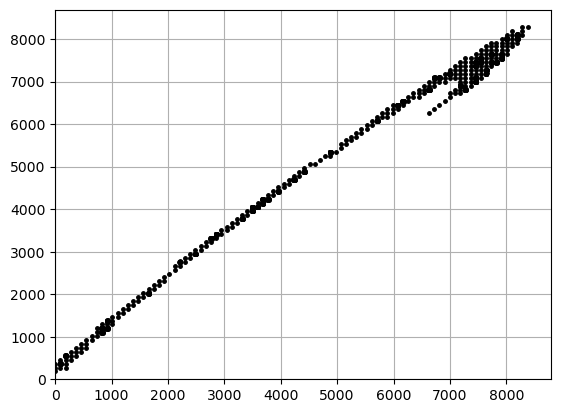

no of gens 0
initial size 272
extra points 222 <class 'int'>
number of points to mutate 700


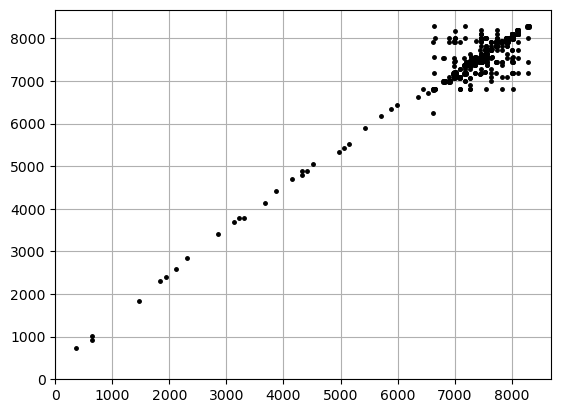

no of gens 1
initial size 272
extra points 222 <class 'int'>
number of points to mutate 700


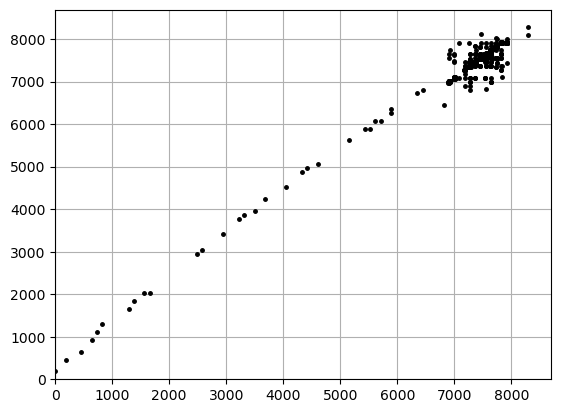

no of gens 2
initial size 272
extra points 222 <class 'int'>
number of points to mutate 700


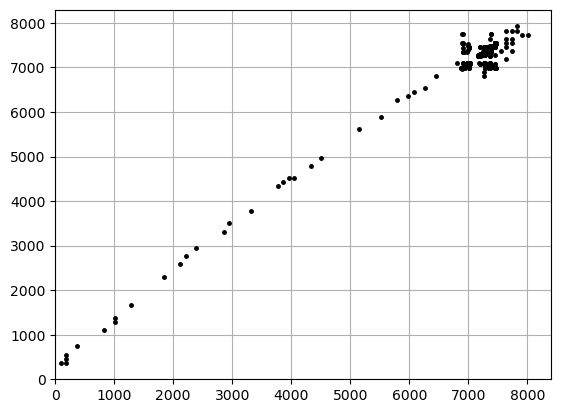

no of gens 3
initial size 272
extra points 222 <class 'int'>
number of points to mutate 700


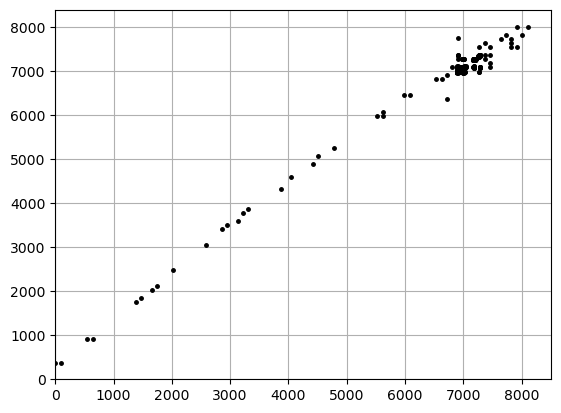

no of gens 4
initial size 272
extra points 222 <class 'int'>
number of points to mutate 700


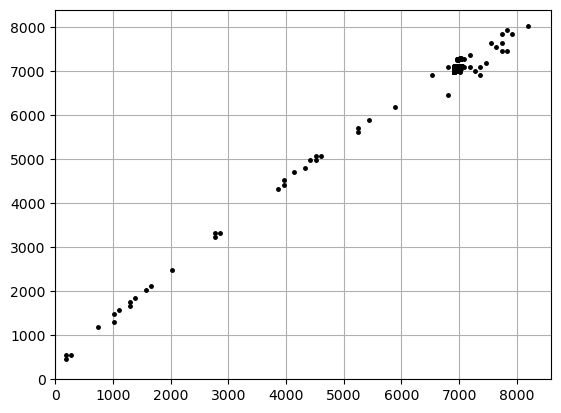

no of gens 5
initial size 272
extra points 222 <class 'int'>
number of points to mutate 700


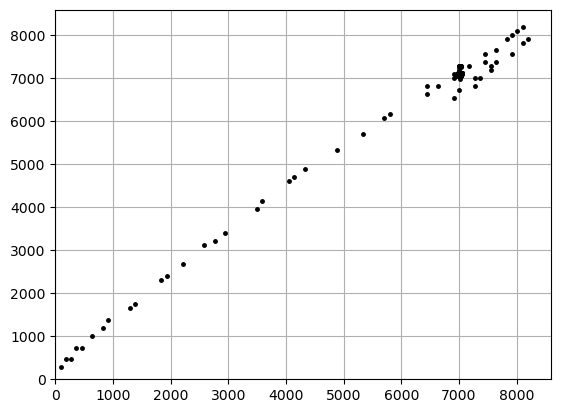

no of gens 6
initial size 272
extra points 222 <class 'int'>
number of points to mutate 700


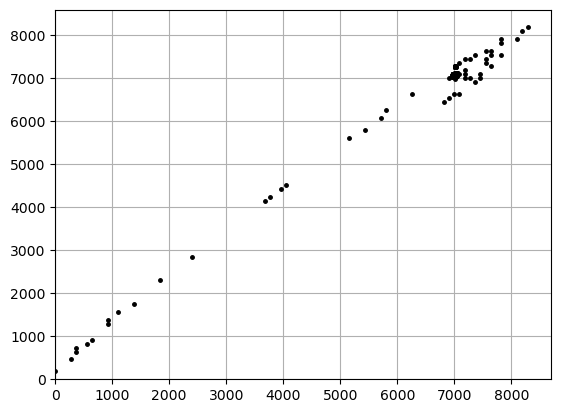

no of gens 7
initial size 272
extra points 222 <class 'int'>
number of points to mutate 700


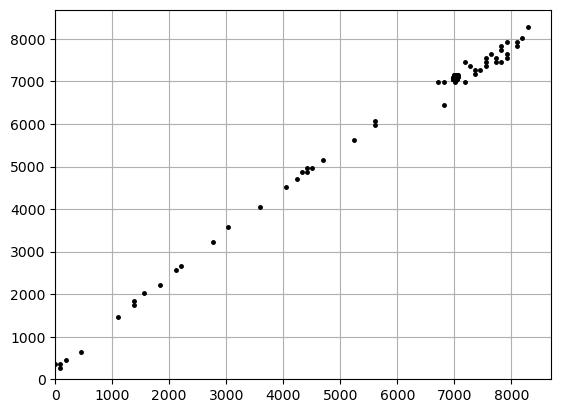

no of gens 8
initial size 272
extra points 222 <class 'int'>
number of points to mutate 700


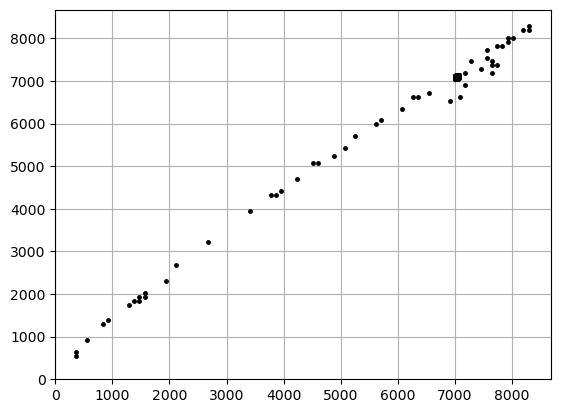

no of gens 9
initial size 272
extra points 222 <class 'int'>
number of points to mutate 700


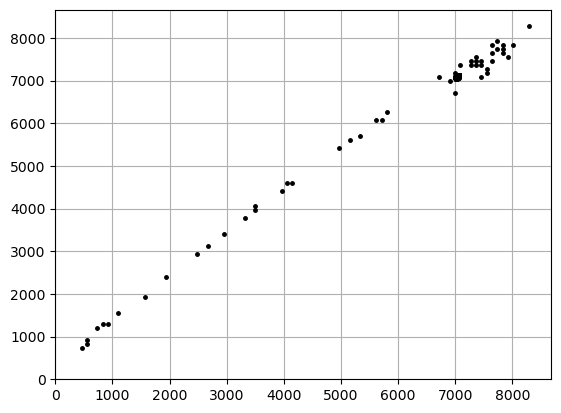

no of gens 10
initial size 272
extra points 222 <class 'int'>
number of points to mutate 700


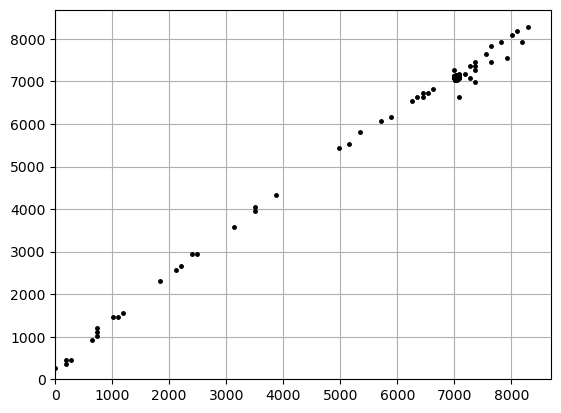

no of gens 11
initial size 272
extra points 222 <class 'int'>
number of points to mutate 700


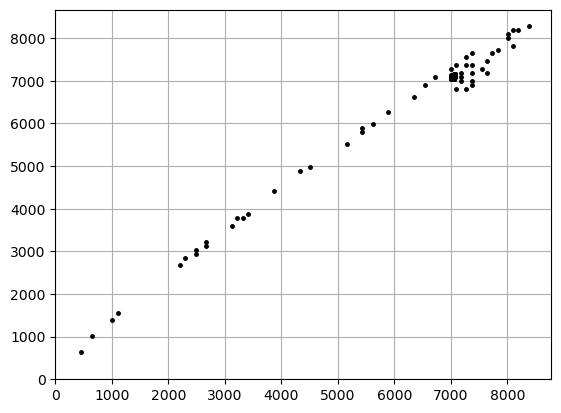

similarity in last best
donzo
{'Point': [7022.320000000001, 7096.39], 'Orbit': [array([ 1968.17786357, -6776.96368435,  -189.61361604]), (6.42190237954805, 1.343048105291981, 3.8125970625286207)], 'Fit': Decimal('0.9999999996165088153034525987')}


In [382]:
# measurments from detecting objects
set_of_measurments = test2
    
#set up the pop
r1 = set_of_measurments[0][:-1]
r2 = set_of_measurments[-1][:-1]
tof = set_of_measurments[-1][-1] - set_of_measurments[0][-1]
ti = set_of_measurments[0][-1]
# initialise
data, limit = initialise_pop(elements_sat, r1, r2, ti, TOF=tof, N=1000)
show_pop(data)
# run the objective func
data = objective_func(elements_sat, set_of_measurments, data)

#initialise the body of the alogithm
best_point = get_best(data)["Point"]
no_of_gens = 0
phi = 4
#print("best point", best_point)
last_means = [(0,0) for x in range(phi)]
last_means.pop(0)
last_means.append(mean(data))

last_best_values = [(0,0) for x in range(phi)]
last_best_values.pop(0)
last_best_values.append(best_point)

D, rO_perigee = evaluate_D(elements_sat, tof)  # maybe there is a better way to define this

# body
while stop_criteria(data, last_means, last_best_values, no_of_gens) is False:
    print("no of gens", no_of_gens)
    #print("iteration", no_of_gens)
    data_elite = get_elite(data, n=100)
       
    # create new population and corresponding orbits
    data_created, limit = initialise_pop(elements_sat, r1, r2, ti, TOF=tof, N=50, limit=limit)  # create 5% of desired population size
            
    #mutate
    data_mutation = mutation(data_elite, elements_sat, r1,r2, rO_perigee, ti, tof, 700)  # 800 corresponds to 80% of desired population 
    #print("mutation", check_duplicates(data_mutation))
    # crossover
    data_crossover = crossover(data_mutation, elements_sat, r1,r2, rO_perigee, ti, tof, 50, D)  # crossover 5% of desired population size
    data = data_crossover + data_created
            
    #print("final", len(data))
    #print("crossover", check_duplicates(data_crossover))
    # get new fit_values
    data = objective_func(elements_sat, set_of_measurments, data)
            
    # update last_means, last_best_values, no_of_gens
    last_means.pop(0)
    last_means.append(mean(data))
    #print("last means", last_means)
    best_point = get_best(data)["Point"]
    #print("the best", best_point)
    last_best_values.pop(0)
    last_best_values.append(best_point)
    
    show_pop(data)
    no_of_gens += 1
else:
    print("donzo")
    best = get_best(data)
    print(best)


In [29]:
pykep.ic2par([ 1968.17786357, -6776.96368435,  -189.61361604],[6.42190237954805, 1.343048105291981, 3.8125970625286207], mu=398600)

(7202.106850539497,
 0.056140281362851936,
 0.5296849595234379,
 5.040942623366778,
 4.966501534761335,
 1.2104106822003384)

In [33]:
np.degrees(1.2104106822003384)

69.35142356763015

Test fitness value of a given orbit

In [123]:
j =0
elements_deb = orbits[j]["Orbit"]
#elements_deb = [9810.004519,0.262562598,np.radians(79.10762144),np.radians(39.25035365),np.radians(219.9865093),np.radians(-2.933878265)]
new_test = all_rel[j]["list in global axis"]
ti = new_test[0][-1]
print("initial time",ti)

print("elements",elements_deb)

orbit = propagate(elements_deb,ti,kepler=True)
print("orbit", orbit)
fitness(elements_sat, new_test, orbit, test=True)

initial time 1
elements (9811.475937319046, 0.2626769219772747, 1.3806700565091157, 0.6850316417322531, 3.839412064813702, -0.052022489230542944)
orbit (9811.475937319046, 0.2626769219772747, 1.3806700565091155, 0.6850316417322531, 3.839412064813702, -0.051141838782611304)
time 1
L ast [Decimal('-0.05335857050805853745195961072')
 Decimal('0.5177069995686846183687037657')
 Decimal('0.8538924554947926989224624848')]
measured unit vector in global CS [Decimal('-0.05335857050808311859134080311')
 Decimal('0.5177069995686644004033378444')
 Decimal('0.8538924554948034208437878453')]
dot 0.9999999999999999999999999994
time 2
L ast [Decimal('-0.04568639547432825802267966013')
 Decimal('0.5198621418486778934728346427')
 Decimal('0.8530276119452806923324286975')]
measured unit vector in global CS [Decimal('-0.04568639547435284910787052162')
 Decimal('0.5198621418486637730893059818')
 Decimal('0.8530276119452879806953078122')]
dot 0.9999999999999999999999999991
time 3
L ast [Decimal('-0.03791983

Decimal('0.9999999999999999999999996292')

Debug

In [377]:
validating_alg = []
for t in range(80):
    r,v = propagate(elements_sat, t, kepler=False)
    validating_alg.append(r)
%store validating_alg

Stored 'validating_alg' (list)


In [45]:
new_test = all_rel[j]["list in global axis"]
ti = new_test[0][-1]
tf = new_test[-1][-1]
tof = tf - ti
point = (108.6398288734075225263733372,108.9334539151836614702672220)
print("initial time",ti)
print("final time", tf)
print("tof",tof)
ri, rf = get_target_r(elements_sat, new_test[0][:-1],new_test[-1][:-1],point,ti,tof)
ri, vi = solve_lambert(ri,rf,tof)
constraints(ri,vi, rO_perigee)

initial time 1
final time 59
tof 58


True

In [181]:
elements_deb = orbits[0]["Orbit"]
elements_sat = [7350,0.0037296,np.radians(82.0394),np.radians(41.7294),np.radians(216.168),np.radians(0)]
for t in range(39):
    r1, v1 = propagate_based_on_elements(elements_sat, t, kepler=False)
    r2,v2 = propagate_based_on_elements(elements_deb, t, kepler=False)
    rel_v = v2 - v1
    print("time", t+6)
    print("dv", rel_v/np.linalg.norm(rel_v))

time 6
dv [ 0.87716951  0.04240968 -0.47830437]
time 7
dv [ 0.87721863  0.04240665 -0.47821454]
time 8
dv [ 0.87726789  0.04240378 -0.47812443]
time 9
dv [ 0.87731728  0.04240108 -0.47803404]
time 10
dv [ 0.8773668   0.04239853 -0.47794336]
time 11
dv [ 0.87741646  0.04239615 -0.47785242]
time 12
dv [ 0.87746624  0.04239392 -0.4777612 ]
time 13
dv [ 0.87751614  0.04239184 -0.47766971]
time 14
dv [ 0.87756618  0.04238991 -0.47757795]
time 15
dv [ 0.87761633  0.04238812 -0.47748594]
time 16
dv [ 0.87766661  0.04238648 -0.47739366]
time 17
dv [ 0.87771701  0.04238497 -0.47730113]
time 18
dv [ 0.87776752  0.0423836  -0.47720835]
time 19
dv [ 0.87781815  0.04238236 -0.47711532]
time 20
dv [ 0.8778689   0.04238125 -0.47702204]
time 21
dv [ 0.87791976  0.04238027 -0.47692852]
time 22
dv [ 0.87797073  0.0423794  -0.47683476]
time 23
dv [ 0.87802181  0.04237866 -0.47674076]
time 24
dv [ 0.878073    0.04237803 -0.47664653]
time 25
dv [ 0.87812429  0.04237751 -0.47655207]
time 26
dv [ 0.87817569 

In [180]:
for dict1 in all_coordinates:
    last_point = None
    for point in dict1["new_list"]:
        if last_point is None:
            time = point[-1]
            r,v = propagate_based_on_elements(elements_sat, time, kepler=False)
            last_point = to_global_axis(point[:-1],r,v)
            last_point = np.append(last_point,[time])
        else:
            time = point[-1]
            print("time", time)
            r,v = propagate_based_on_elements(elements_sat, time, kepler=False)
            point = to_global_axis(point[:-1],r,v)
            print("last",last_point)
            print("current", point)
            dr = point-last_point[:-1]
            dt = time - last_point[-1]
            dv = dr/dt
            dv = dv/np.linalg.norm(dv)
            print("dv",dv)
            last_point = np.append(point, [time])

time 6.0
last [0.04767102 0.54649049 0.83610742 5.        ]
current [0.07172828 0.55239944 0.83048776]
dv [ 0.94707154  0.23262003 -0.22123158]
time 7.0
last [0.07172828 0.55239944 0.83048776 6.        ]
current [0.09619167 0.55778345 0.82439359]
dv [ 0.94894652  0.20884823 -0.23639568]
time 8.0
last [0.09619167 0.55778345 0.82439359 7.        ]
current [0.12173451 0.5633007  0.81723499]
dv [ 0.94272485  0.20362872 -0.26420675]
time 9.0
last [0.12173451 0.5633007  0.81723499 8.        ]
current [0.1471605  0.56861303 0.80933492]
dv [ 0.9365067   0.19566697 -0.29098049]
time 10.0
last [0.1471605  0.56861303 0.80933492 9.        ]
current [0.17283244 0.57329788 0.80091103]
dv [ 0.93618532  0.17084389 -0.30719605]
time 11.0
last [ 0.17283244  0.57329788  0.80091103 10.        ]
current [0.19907176 0.57766253 0.79162897]
dv [ 0.9313695   0.15492396 -0.32946838]
time 12.0
last [ 0.19907176  0.57766253  0.79162897 11.        ]
current [0.22582675 0.58166428 0.7814531 ]
dv [ 0.92567744  0.138

In [152]:
data = [{"point":2}, {"point":2}]

In [153]:
check_duplicates(data)

(True, [{'point': 2}])

In [44]:
set_of_measurments = data_meas.loc[0]  #choose which line to check
set_of_measurments = normalise_input(set_of_measurments.dropna())

In [24]:
%store -r line

In [25]:
%store -r B_CS

In [42]:
test = line

In [ ]:
test = B_CS
new_test = []
for t in range(len(B_CS)):
    new_test.append(np.append(B_CS[t],[t]))
new_test = new_test[15:]

In [160]:
ri,vi = propagate_based_on_elements(elements_deb, 15, kepler=False)
rf, vf = propagate_based_on_elements(elements_deb, 20, kepler=False)
print(rf)
t = 5
l = pykep.lambert_problem(r1 = ri, r2 = rf, tof = t, mu=398600)
# convert results
vi = l.get_v1()[0]  # get the velocity vector at initial time for one revolution
elements = pykep.ic2par(ri,vi, mu=398600)  # get Kepler elements from pos and vel vectors
propagate_based_on_elements(elements,-5,kepler=False)

[7101.54467811  147.85122      26.07015922]


(array([7102.72965339,   73.92972254,   13.03580476]),
 array([-0.07900058,  7.39269804,  1.30353212]))

In [99]:
to_global_axis([0.01673061, 0.99673921, 0.07893691],r,v)

array([-0.99687808,  0.00174933,  0.07893691])

In [50]:
ri,vi = propagate_based_on_elements(elements_deb, 15, kepler=False)
ri

array([7102.23590559,  110.89201231,   19.55325372])

In [49]:
r,v = pykep.par2ic([7251.530635158399,
   0.04727894735094815,
   0.3043583371135131,
   6.283181747953716,
   6.272813707430835,
   0.02599273515476623], mu=398600)
r

(6907.8178091061245, 111.23317920976065, 34.948078905783575)

In [108]:
path = "data\M1\measurments_data_0_0_M1.csv"
# measurments from detecting objects
data_meas = pd.read_csv(path)
for index, row in data_meas.iterrows():
    data = []
    set_of_measurments = normalise_input(row.dropna())
    fit = fitness(elements_sat, set_of_measurments, [7819.880086052383,
 0.06117955693343069,
 0.01676014693654946,
 0.023853899055801767,
 0.036618487883039695,
 -0.04398210673175327])
    print(fit)

0.991689075683478
2.0808244582155924e-22
-1.2927927856016754e-12


In [45]:
fits=[]
for i in range(len(data_meas)):
    set_of_measurments = data_meas.loc[i]  #choose which line to check
    set_of_measurments = normalise_input(set_of_measurments.dropna())
    fit = fitness(elements_sat, new_test, [7133.8,0.0043,np.radians(10),np.radians(0),np.radians(0),0.015785194118121015])
    fits.append(fit)

NameError: name 'data_meas' is not defined

In [201]:
max(fits)

0.9999999999999986

In [146]:
v = [0,1,0]
r = [1,0,0]
vec = [0,1,0]
to_global_axis(vec,r,v)

array([-1.,  0.,  0.])

In [147]:
print(best_point)

D, rO_perigee = evaluate_D(elements_sat, 60)
# Set up Lambert's problem
rT_i, rT_f = get_target_r(elements_sat,elements_deb, [4686.363636363637, 4686.363636363637], 60)
# solve Lambert's problem
elementsT_estimated = list(solve_lambert(r1 = rT_i, r2 = rT_f, tof = 60))
print(elementsT_estimated)
fit = fitness(elements_sat, elements_deb, elementsT_estimated, no_of_measurments = 60)
print(fit)

[1019.3239436619718, 639.0422535211268]


TypeError: get_target_r() missing 1 required positional argument: 't'

In [262]:
print("from rho",propagate_based_on_elements([6929.3203653797,0.0300116531,1.7162873512,0.8762504074,5.7380713477,3.1008175552], 0, kepler=False))
print("ideal", propagate_based_on_elements(elements_deb, 0, kepler=False))

print("satellite", propagate_based_on_elements(elements_sat,0, kepler=False))

print(unit_vector(propagate_based_on_elements(elements_sat,0, kepler=False)[0], propagate_based_on_elements([6929.3203653797,0.0300116531,1.7162873512,0.8762504074,5.7380713477,3.1008175552], 0, kepler=False)[0]))

print(unit_vector(propagate_based_on_elements(elements_sat,0, kepler=False)[0], propagate_based_on_elements(elements_deb, 0, kepler=False)[0]))

from rho (array([-3370.40082161, -4938.35873329,  3897.60440158]), array([-3.28804323, -2.55804492, -6.06789951]))
ideal (array([ 2644.71527012, -6597.70363665,   203.65960376]), array([6.1781863 , 2.13873564, 3.83254291]))
satellite (array([-3407.72971403, -4928.06109229,  3920.52845889]), array([-3.34761025, -2.58520094, -6.12964399]))
[ 0.82953094 -0.22883647 -0.50942349]
[ 0.82953093 -0.22883647 -0.5094235 ]


In [ ]:
fit = fitness(elements_sat, elements_deb, [9450.49625553981, 0.2501664703342994, 1.7154666684924387, 0.8703258847995052, 2.9719140826855535, -2.995440490696146], no_of_measurments = 60)
fit

Python reminder

In [81]:
round(-0.5)

0

In [115]:
L = random.choice([1,3,6,2,4])
L


1

In [113]:
f = False
n = 0
while f == False:
    n +=1
    if n == 3:
        print("here")
        f = False
        break
    print(n)

1
2
here


In [55]:
l = [x for x in range(4)]
l

[0, 1, 2, 3]

In [ ]:
l = [{"brand": "Ford",
  "model": "Mustang",
  "year": 1964
}, {
  "brand": "Volvo",
  "model": "SUV",
  "year": 2018
},
{"brand": "Audi",
  "model": "A7",
  "year": 2013},
  ]

for dict1 in l:
    if dict1["year"] >= 2000:
        dict1["new"] = True

# order l based on year
years = []
for dict1 in l:
    years.append(dict1["year"])
    years.sort()

years

[1964, 2013, 2018]

In [ ]:
e1 = [9450.49625553981, 0.2501664703342994, 1.7154666684924387, 0.8703258847995052, 2.9719140826855535, -2.995440490696146]
r, v = pykep.par2ic(e1, mu=398600)
rf,vf = pykep.propagate_lagrangian(r0 = r, v0 = v, tof = 50,mu = 398600)
e2 = pykep.ic2par(rf,vf,mu = 398600)
e2

(9450.496255539807,
 0.25016647033429984,
 1.7154666684924387,
 0.8703258847995052,
 2.971914082685554,
 -2.9678853860378602)

In [ ]:
np.radians(180)

3.141592653589793

In [47]:
for t in range(2):
    print(t)

0
1
